# Sign Language Detection with Artificial Neural Networks

In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sign-language-digits-dataset/Y.npy
/kaggle/input/sign-language-digits-dataset/X.npy
/kaggle/input/sign-language-digits-dataset/Sign-language-digits-dataset/Y.npy
/kaggle/input/sign-language-digits-dataset/Sign-language-digits-dataset/X.npy


## Getting and Processing Data

(-0.5, 63.5, 63.5, -0.5)

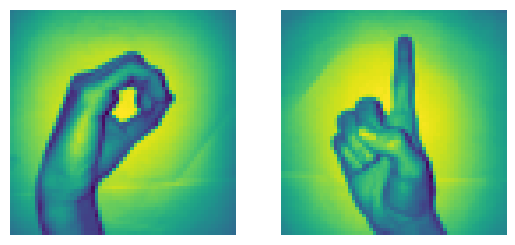

In [32]:
# load data set
x_l = np.load('/kaggle/input/sign-language-digits-dataset/X.npy')
Y_l = np.load('/kaggle/input/sign-language-digits-dataset/Y.npy')
img_size = 64
plt.subplot(1, 2, 1)
plt.imshow(x_l[260].reshape(img_size, img_size))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_l[900].reshape(img_size, img_size))
plt.axis('off')

In [33]:
# Join a sequence of arrays along an row axis.
X = np.concatenate((x_l[204:409], x_l[822:1027] ), axis=0) # from 0 to 204 is zero sign and from 205 to 410 is one sign 
z = np.zeros(205)
o = np.ones(205)
Y = np.concatenate((z, o), axis=0).reshape(X.shape[0],1)
print("X shape: " , X.shape)
print("Y shape: " , Y.shape)

X shape:  (410, 64, 64)
Y shape:  (410, 1)


In [34]:
# Then lets create x_train, y_train, x_test, y_test arrays
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]

In [35]:
X_train_flatten = X_train.reshape(number_of_train,X_train.shape[1]*X_train.shape[2])
X_test_flatten = X_test .reshape(number_of_test,X_test.shape[1]*X_test.shape[2])
print("X train flatten",X_train_flatten.shape)
print("X test flatten",X_test_flatten.shape)

X train flatten (348, 4096)
X test flatten (62, 4096)


In [36]:
x_train = X_train_flatten.T
x_test = X_test_flatten.T
y_train = Y_train.T
y_test = Y_test.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (4096, 348)
x test:  (4096, 62)
y train:  (1, 348)
y test:  (1, 62)


In [37]:
# calculation of z
#z = np.dot(w.T,x_train)+b
def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head
#y_head = sigmoid(z)

# Artificial Neural Networks

In [38]:
def initialize_parameters_and_layer_sizes_NN(x_train, y_train):
    parameters = {"weight1": np.random.randn(3, x_train.shape[0]) * 0.1,  # 4,4096 alıyoruz bc 3 node için 4096şar
                 "bias1": np.zeros((3,1)),  # bias eklenecek o yüzden 3,1 aynı sayıda 
                 "weight2": np.random.randn(y_train.shape[0],3) * 0.1,  # burada 1,1 çıkacak bc it is for outp layer
                 "bias2": np.zeros((y_train.shape[0],1))}  # 1,1 olcak
    return parameters

## Forward Propag

In [39]:
def forward_propagation_NN(x_train, parameters):  # x_train ve initializedekil parametreleri aldık
    Z1 = np.dot(parameters["weight1"], x_train) + parameters["bias1"]  # weight 1 ile x_traini çarpıp bias ekledik
    A1 = np.tanh(Z1)  # tanh fonksiyonuna soktuk
    Z2 = np.dot(parameters["weight2"], A1) + parameters["bias2"]  # A1 değerini weight 2 ile çarpıp bias ekledik
    A2 = sigmoid(Z2)  # sigmoid
    
    cache = {"Z1": Z1,
            "A1": A1,
            "Z2": Z2,
            "A2": A2}
    
    return A2, cache

## Computing loss and cost
Elde ettiğimiz değerleri gerçek Y değerleri ile kıyaslama

In [40]:
def compute_cost_NN(A2, Y, parameters):  # A2 outp layere gittiği için alıyoruz
    logprobs = np.multiply(np.log(A2), Y)
    cost = -np.sum(logprobs)/Y.shape[1]
    return cost

## Backward Propagation

In [41]:
# Backward Propagation | buradakiler hep derivative
def backward_propagation_NN(parameters, cache, X, Y):    # X images, Y labels

    dZ2 = cache["A2"]-Y  
    dW2 = np.dot(dZ2,cache["A1"].T)/X.shape[1]
    db2 = np.sum(dZ2,axis =1,keepdims=True)/X.shape[1]
    dZ1 = np.dot(parameters["weight2"].T,dZ2)*(1 - np.power(cache["A1"], 2))
    dW1 = np.dot(dZ1,X.T)/X.shape[1]
    db1 = np.sum(dZ1,axis =1,keepdims=True)/X.shape[1]
    grads = {"dweight1": dW1,
             "dbias1": db1,
             "dweight2": dW2,
             "dbias2": db2}
    return grads

## Update Parameters

In [42]:
# update parameters
def update_parameters_NN(parameters, grads, learning_rate=0.01):
    parameters = {"weight1": parameters["weight1"] - learning_rate*grads["dweight1"],
                 "bias1": parameters["bias1"] - learning_rate*grads["dbias1"],
                 "weight2": parameters["weight2"] - learning_rate*grads["dweight2"],
                 "bias2": parameters["bias2"] - learning_rate*grads["dbias2"]}
    return parameters

## Prediction with learnt parameters weight and bias

In [43]:
def predict_NN(parameters, x_test):
    # x_test is a input for forward propagation
    A2, cache = forward_propagation_NN(x_test, parameters)
    Y_prediction = np.zeros((1, x_test.shape[1]))
    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0),
    for i in range(A2.shape[1]):
        if A2[0,i] <= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1
            
    return Y_prediction

## Create Model
* Lets put them all together

In [44]:
def two_layer_neural_network(x_train, y_train, x_test, y_test, num_iterations):
    cost_list = []
    index_list = []
    
    # initialize parameters and layer sizes
    parameters = initialize_parameters_and_layer_sizes_NN(x_train, y_train)
    
    for i in range(0, num_iterations):
        # forward propagation
        A2, cache = forward_propagation_NN(x_train, parameters) 
        # compute cost
        cost = compute_cost_NN(A2, y_train, parameters)
        # backward propagation
        grads = backward_propagation_NN(parameters, cache, x_train, y_train)
        # update parameters
        parameters = update_parameters_NN(parameters, grads)
        
        if i % 100 == 0:
            cost_list.append(cost)
            index_list.append(i)
            print("Cost after iteration %i: %f" %(i, cost))
            
    plt.plot(index_list, cost_list)
    plt.xticks(index_list, rotation='vertical')
    plt.xlabel("Number of iteration")
    plt.ylabel("Cost")
    plt.show()
    
    # predict
    y_prediction_test = predict_NN(parameters, x_test)
    y_prediction_train = predict_NN(parameters, x_train)
    
    # print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    return parameters



Cost after iteration 0: 0.309890
Cost after iteration 100: 0.330085
Cost after iteration 200: 0.337253
Cost after iteration 300: 0.340396
Cost after iteration 400: 0.340219
Cost after iteration 500: 0.327303
Cost after iteration 600: 0.301044
Cost after iteration 700: 0.264632
Cost after iteration 800: 0.225944
Cost after iteration 900: 0.192640
Cost after iteration 1000: 0.166167
Cost after iteration 1100: 0.159547
Cost after iteration 1200: 0.128837
Cost after iteration 1300: 0.114026
Cost after iteration 1400: 0.101881
Cost after iteration 1500: 0.092056
Cost after iteration 1600: 0.090373
Cost after iteration 1700: 0.078548
Cost after iteration 1800: 0.070971
Cost after iteration 1900: 0.064630
Cost after iteration 2000: 0.059336
Cost after iteration 2100: 0.054993
Cost after iteration 2200: 0.051344
Cost after iteration 2300: 0.048207
Cost after iteration 2400: 0.045490


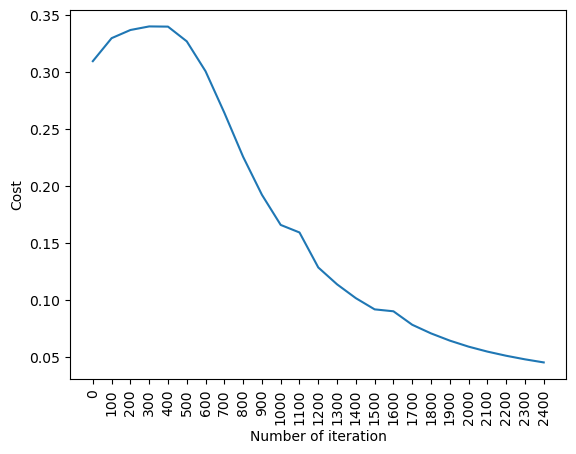

train accuracy: 99.71264367816092 %
test accuracy: 91.93548387096774 %


In [45]:
parameters = two_layer_neural_network(x_train, y_train,x_test,y_test, num_iterations=2500)

# L Layer Neural Network

In [46]:
# reshaping
x_train, x_test, y_train, y_test = x_train.T, x_test.T, y_train.T, y_test.T

## Implementing with keras library
Lets look at some parameters of keras library:
* units: output dimensions of node
* kernel_initializer: to initialize weights
* activation: activation function, we use relu
* input_dim: input dimension that is number of pixels in our images (4096 px)
* optimizer: we use adam optimizer
    * Adam is one of the most effective optimization algorithms for training neural networks.
    * Some advantages of Adam is that relatively low memory requirements and usually works well even with little tuning of hyperparameters
* loss: Cost function is same. By the way the name of the cost function is cross-entropy cost function that we use previous parts.
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$
* metrics: it is accuracy.
* cross_val_score: use cross validation. 
* epochs: number of iteration

In [47]:
# Evaluating the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential # initialize neural network library
from keras.layers import Dense # build our layers library
def build_classifier():
    classifier = Sequential() # initialize neural network
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train.shape[1]))
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier, epochs = 100)
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 3)
mean = accuracies.mean()
variance = accuracies.std()
print("Accuracy mean: "+ str(mean))
print("Accuracy variance: "+ str(variance))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Epoch 1/100
8/8 [==============================] - 1s 4ms/step - loss: 0.6927 - accuracy: 0.5345
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5431
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5431
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5431
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5431
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5431
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.5431
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5431
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.5431
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.5431
Epoch 11/100
8/8 [===========